<a href="https://colab.research.google.com/github/shahdhruv29/mnist-classification-lenet5-pytorch/blob/main/mlp3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Implemented the LeNet-5 Architecture on the digits 4, 9 and 3.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the train data

df=pd.read_csv('/content/drive/MyDrive/MNIST/mnist_train.csv')
print(df.shape) 


#Convert df to pytorch tensor
data=df.values
print(type(data))
# print(data.shape)

X_train=data[:,1:]
Y_train=data[:,0]
print(X_train.shape,Y_train.shape)

(60000, 785)
<class 'numpy.ndarray'>
(60000, 784) (60000,)


In [ ]:
#A function to remove all the digits except 4 and 9 and 3.
def remove(digit, x, y):
    idx = (y != digit).nonzero()
    return x[idx], y[idx]

X_train, Y_train = remove(0, X_train, Y_train)
X_train, Y_train = remove(1, X_train, Y_train)
X_train, Y_train = remove(2, X_train, Y_train)
X_train, Y_train = remove(5, X_train, Y_train)
X_train, Y_train = remove(6, X_train, Y_train)
X_train, Y_train = remove(7, X_train, Y_train)
X_train, Y_train = remove(8, X_train, Y_train)


print(X_train.shape, Y_train.shape)



(17922, 784) (17922,)


In [ ]:
#Function to convert the labels to binary labels
def convert_to_ternary(Y_train):
    Y_train[Y_train==4]=0
    Y_train[Y_train==9]=1
    Y_train[Y_train==3]=2
    return Y_train

Y_train=convert_to_ternary(Y_train)
print(Y_train[:10])

[0 1 2 0 2 2 1 0 1 0]


In [ ]:
#Here Y_train got appended in the last column of Data_new.

Data_new = np.append(X_train, Y_train.reshape(-1,1), axis=1)
print(Data_new.shape)
print(Data_new[:10,784])

(17922, 785)
[0 1 2 0 2 2 1 0 1 0]


In [ ]:
Transform = transforms.ToTensor()
Data_new= Transform(Data_new)
print(Data_new.shape)

X_train=Data_new[0,:,1:]
Y_train=Data_new[0,:,784:]
print(X_train.shape)
print(Y_train.shape)  


#Visualize the data
img, label = X_train[0,:], Y_train[0,0]
print(img.shape, label)

torch.Size([1, 17922, 785])
torch.Size([17922, 784])
torch.Size([17922, 1])
torch.Size([784]) tensor(0)


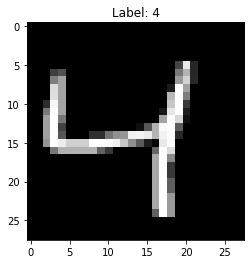

In [ ]:
plt.imshow(img.reshape(28,28), cmap='gray')
if label==0:
    plt.title('Label: 4')
elif label==1:
    plt.title('Label: 9')
else:
    plt.title('Label: 3')
plt.show()


In [ ]:
#Resize each image to 28x28
X_train=X_train.reshape(-1,28,28) #60000 images of 28x28
print(X_train.shape)


#Add padding to make the image 32x32
X_train=torch.nn.functional.pad(X_train, (2,2,2,2), 'constant', 0)
print(X_train.shape)

torch.Size([17922, 28, 28])
torch.Size([17922, 32, 32])


In [ ]:
#Normalize the data
X_train.type(torch.float32)
mean=torch.mean(X_train.type(torch.float32))
std=torch.std(X_train.type(torch.float32))
X_train = (X_train-mean)/std 
print(X_train.shape)


torch.Size([17922, 32, 32])


In [ ]:
batch_size=8
num_classes=3

train_loader = torch.utils.data.DataLoader(dataset=X_train, batch_size=batch_size, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
#Build a LeNet-5 model without ReLU 
class LeNet5(nn.Module):
    def __init__(self) :
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,6,kernel_size=5,stride=1,padding=0),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6,16,kernel_size=5,stride=1,padding=0),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16,120,kernel_size=5,stride=1,padding=0),
        )

        self.fc=nn.Linear(120,84)
        self.fc1=nn.Linear(84,10)
        self.fc2=nn.Linear(10,3)
    
    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=out.reshape(out.size(0),-1)
        out=self.fc(out)
        # out=self.relu(out)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

In [ ]:
#Setting the loss function and optimizer
model = LeNet5().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc): Linear(in_features=120, out_features=84, bias=True)
  (fc1): Linear(in_features=84, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)


In [ ]:
#Training the model
total_step = len(train_loader)
num_epochs = 5
acc_history = []
loss_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    running_loss = 0.0
    running_corrects = 0
    
    for i in range(total_step):
        # print(X[i].shape)
        images = X_train[i].reshape(1,1,32,32).to(device)
        # print(images.shape)
        labels = Y_train[i,:].to(device)
        # print(labels.shape)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / total_step
    epoch_acc = running_corrects.double() / total_step

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)

Epoch 0/4
----------
Loss: 0.0287 Acc: 0.9915
Epoch 1/4
----------
Loss: 0.0290 Acc: 0.9929
Epoch 2/4
----------
Loss: 0.0579 Acc: 0.9853
Epoch 3/4
----------
Loss: 0.0167 Acc: 0.9955
Epoch 4/4
----------
Loss: 0.0479 Acc: 0.9875


In [ ]:
# Save the model using in pkl format
torch.save(model.state_dict(), '/content/drive/MyDrive/MNIST/mlp_model3.pkl')

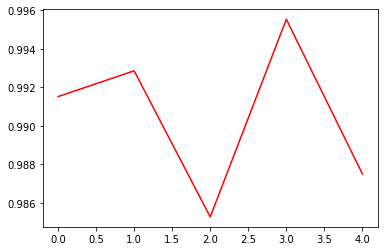

In [ ]:
plt.plot(acc_history, color='r')

In [ ]:
#Loading the test data
df2=pd.read_csv('/content/drive/MyDrive/MNIST/mnist_test.csv')
print(df2.shape)


#Convert df to pytorch tensor
data2=df2.values
print(type(data2))

X_test=data2[:,1:]
Y_test=data2[:,0]
print(X_test.shape)
print(Y_test.shape)

(10000, 785)
<class 'numpy.ndarray'>
(10000, 784)
(10000,)


In [ ]:
X_test, Y_test = remove(1, X_test, Y_test)
X_test, Y_test = remove(0, X_test, Y_test)
X_test, Y_test = remove(2, X_test, Y_test)
X_test, Y_test = remove(5, X_test, Y_test)
X_test, Y_test = remove(6, X_test, Y_test)
X_test, Y_test = remove(7, X_test, Y_test)
X_test, Y_test = remove(8, X_test, Y_test)

print(X_test.shape, Y_test.shape)

#Convert Y_test to ternary
Y_test=convert_to_ternary(Y_test)
print(Y_test.shape)


(3001, 784) (3001,)
(3001,)


In [ ]:
Data_test=np.append(X_test, Y_test.reshape(-1,1), axis=1)
print(Data_test.shape)

(3001, 785)


In [ ]:
#Transform the data
Data_test= Transform(Data_test)
print(Data_test.shape)

X_test=Data_test[0,:,1:]
Y_test=Data_test[0,:,784:]
print(X_test.shape)
print(Y_test.shape)

#Visualize the data
img, label = X_test[0,:], Y_test[0,0]
print(img.shape, label)

torch.Size([1, 3001, 785])
torch.Size([3001, 784])
torch.Size([3001, 1])
torch.Size([784]) tensor(0)


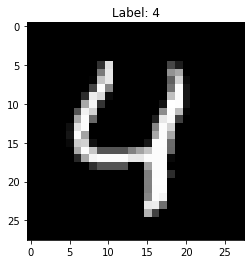

torch.Size([3001, 28, 28])
torch.Size([3001, 32, 32])
torch.Size([3001, 32, 32])


In [ ]:

plt.imshow(img.reshape(28,28), cmap='gray')
if label==0:
    plt.title('Label: 4')
elif label==1:
    plt.title('Label: 9')
else:
    plt.title('Label: 3')
plt.show()

#Resize each image to 28x28
X_test=X_test.reshape(-1,28,28) #60000 images of 28x28
print(X_test.shape)


#Add padding to make the image 32x32
X_test=torch.nn.functional.pad(X_test, (2,2,2,2), 'constant', 0)
print(X_test.shape)


#Normalize the data
X_test.type(torch.float32)
mean=torch.mean(X_test.type(torch.float32))
std=torch.std(X_test.type(torch.float32))
X_test = (X_test-mean)/std
print(X_test.shape)

In [ ]:
#Testing the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i in range(len(X_test)):
        images = X_test[i].reshape(1,1,32,32).to(device)
        labels = Y_test[i,:].to(device)
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 98.30056647784072 %


In [ ]:
#Print a confusion matrix to see the performance of the model
# Here we observed that the accuracy of 4 and 9 goes down when 3 is also trained together with them.
with torch.no_grad():
    n_samples = 0
    n_class_correct = [0 for i in range(3)]
    n_class_samples = [0 for i in range(3)]
    for i in range(len(X_test)):
        images = X_test[i].reshape(1,1,32,32).to(device)
        labels = Y_test[i,:].to(device)
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        n_samples += labels.size(0)
        n_class_samples[labels] += 1
        n_class_correct[labels] += c.item()
    
    for i in range(3):
        switch = {0:4, 1:9, 2:3}
        case = switch.get(i)
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {case} : {acc} %')

Accuracy of 4 : 97.14867617107943 %
Accuracy of 9 : 99.10802775024777 %
Accuracy of 3 : 98.61386138613861 %
